# 🌊 Titanic Survival Prediction — Decision Tree Classifier

Mục tiêu của phần này:
- Xây dựng mô hình **Decision Tree** để dự đoán khả năng sống sót của hành khách trên tàu Titanic.
- Phân tích, trực quan hoá, và đánh giá độ chính xác của mô hình.

Nguồn dữ liệu:
- Dữ liệu đã được tiền xử lý từ `titanic_preprocessing.ipynb`.
- Bao gồm các bước:
  - Xử lý missing values.
  - Tạo đặc trưng mới: `FamilySize`, `IsAlone`, `AgeBin`, `FareBand`, `TicketPrefix`.
  - Mã hoá và chuẩn hoá sẵn sàng cho huấn luyện.

File sử dụng: **`data/processed/titanic_train_preprocessed.csv`**

In [64]:
# 0️⃣ Environment Setup
import os, random, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Thiết lập môi trường tái lập
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.makedirs("models", exist_ok=True)
os.makedirs("data/pic", exist_ok=True)

In [ ]:
# 1️⃣ Load dữ liệu đã tiền xử lý
DATA_PATH = "data/processed/titanic_train_preprocessed.csv"
df = pd.read_csv(DATA_PATH)

print("✅ Dữ liệu đã được load thành công:", df.shape)
display(df.head())

## 2️⃣ Phân bố dữ liệu mục tiêu (Survived)

Ta sẽ trực quan hóa tỷ lệ giữa hai nhóm:
- **0** = Không sống sót  
- **1** = Sống sót  

Điều này giúp kiểm tra xem dữ liệu có bị **mất cân bằng lớp (class imbalance)** hay không.

C:\Users\HOME\AppData\Local\Temp\ipykernel_3392\2264491406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='coolwarm')


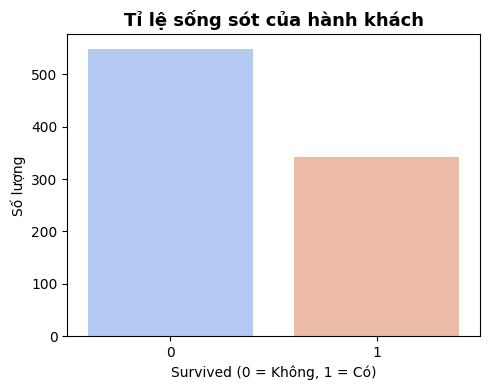

In [65]:
plt.figure(figsize=(5,4))
sns.countplot(x='Survived', data=df, palette='coolwarm')
plt.title("Tỉ lệ sống sót của hành khách", fontsize=13, fontweight='bold')
plt.xlabel("Survived (0 = Không, 1 = Có)")
plt.ylabel("Số lượng")
plt.tight_layout()
plt.show()

## 3️⃣ Chia dữ liệu huấn luyện và kiểm thử

- Chia dữ liệu thành:
  - **80%** cho tập huấn luyện.
  - **20%** cho tập kiểm thử.
- Sử dụng `stratify=y` để giữ nguyên tỷ lệ số người sống sót/không sống sót giữa hai tập.
- Biến mục tiêu: `Survived`.

In [66]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train: {X_train.shape} | Validation: {X_val.shape}")

Train: (712, 12) | Validation: (179, 12)


## 4️⃣ Huấn luyện mô hình Decision Tree

Ta huấn luyện hai mô hình Decision Tree với tiêu chí khác nhau:
- **Gini impurity**: đo mức độ không thuần của node.
- **Entropy**: dựa trên khái niệm thông tin (Information Gain).

Sau đó, ta so sánh độ chính xác giữa hai mô hình và chọn mô hình tốt hơn.

In [67]:
models = {
    'Gini': DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5, random_state=SEED),
    'Entropy': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5, random_state=SEED)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    results[name] = accuracy_score(y_val, y_pred)

res_df = pd.DataFrame(list(results.items()), columns=['Criterion', 'Accuracy'])
print("🔍 So sánh độ chính xác giữa hai tiêu chí:")
display(res_df)

best_criterion = res_df.loc[res_df['Accuracy'].idxmax(), 'Criterion']
dt = models[best_criterion]
print(f"🌲 Mô hình được chọn: {best_criterion}")

🔍 So sánh độ chính xác giữa hai tiêu chí:


,Criterion,Accuracy
0,Gini,0.776536
1,Entropy,0.776536


🌲 Mô hình được chọn: Gini


## 5️⃣ Đánh giá hiệu suất mô hình

- Tính **Accuracy** và **Classification Report** (Precision, Recall, F1-score).
- Hiển thị **Confusion Matrix** để thấy mô hình phân loại đúng/sai ở mức nào.

🎯 Accuracy: 0.7765

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



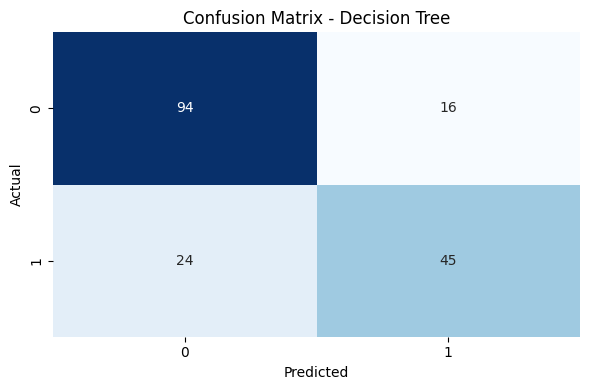

In [68]:
y_pred = dt.predict(X_val)
y_proba = dt.predict_proba(X_val)[:,1]

acc = accuracy_score(y_val, y_pred)
print(f"🎯 Accuracy: {acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("data/pic/confusion_matrix_decision_tree.png", dpi=300)
plt.show()

## 6️⃣ ROC Curve & AUC

Đường cong ROC biểu diễn khả năng phân biệt giữa hai lớp của mô hình.  
Giá trị **AUC (Area Under Curve)** càng cao → mô hình càng tốt.

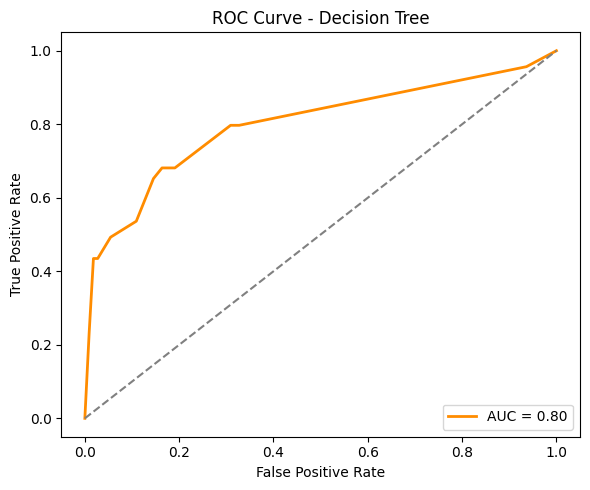

In [69]:
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("data/pic/roc_curve_decision_tree.png", dpi=300)
plt.show()

## 7️⃣ Cấu trúc cây quyết định

Hình dưới đây mô tả cách cây phân nhánh và đưa ra quyết định sống sót dựa trên các đặc trưng.

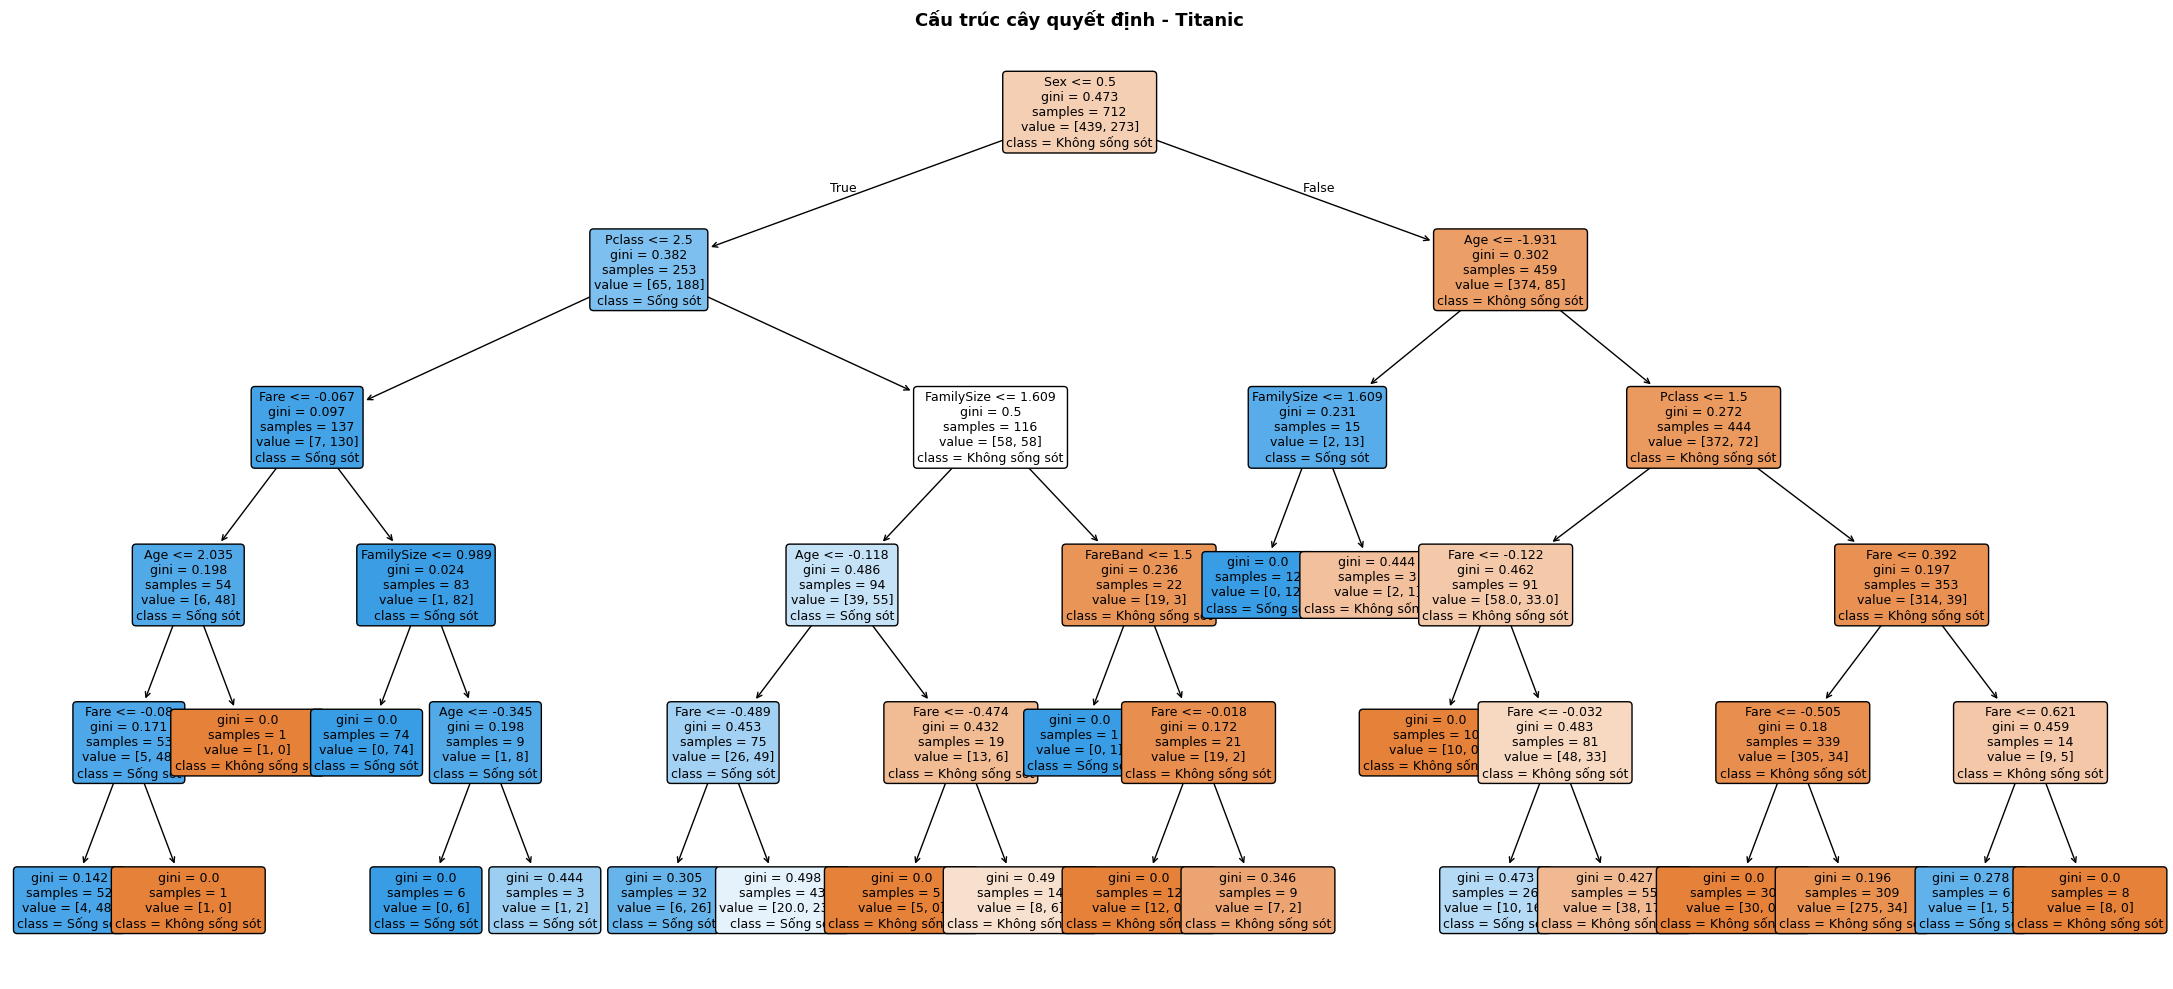

In [70]:
plt.figure(figsize=(22,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=['Không sống sót', 'Sống sót'],
    filled=True, rounded=True, fontsize=9
)
plt.title("Cấu trúc cây quyết định - Titanic", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("data/pic/decision_tree_structure.png", dpi=300)
plt.show()

## 8️⃣ Độ quan trọng của đặc trưng (Feature Importance)

Ta có thể thấy yếu tố nào ảnh hưởng nhiều nhất đến khả năng sống sót:
- Giới tính (`Sex`) gần như là yếu tố mạnh nhất.
- Tiếp theo là `Pclass`, `Age`, và `Fare`.

C:\Users\HOME\AppData\Local\Temp\ipykernel_3392\1917238547.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\HOME\AppData\Local\Temp\ipykernel_3392\1917238547.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HOME\AppData\Local\Temp\ipykernel_3392\1917238547.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("data/pic/feature_importance_decision_tree.png", dpi=300)
C:\Users\HOME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


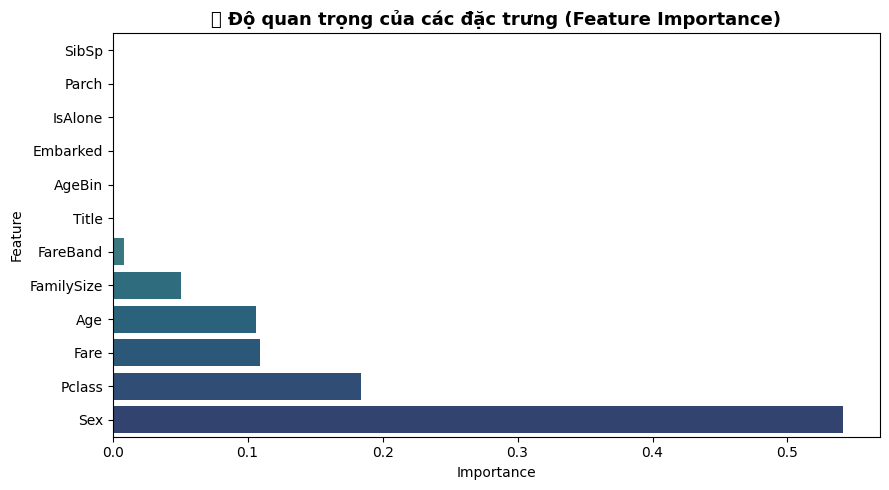

,Feature,Importance
1,Sex,0.541488
0,Pclass,0.184087
5,Fare,0.109166
2,Age,0.106198
7,FamilySize,0.050727
11,FareBand,0.008335
3,SibSp,0.000000
4,Parch,0.000000
6,Embarked,0.000000
8,IsAlone,0.000000


In [72]:
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(
    data=feat_imp.sort_values('Importance', ascending=True),
    x='Importance', y='Feature', palette='crest'
)
plt.title("📊 Độ quan trọng của các đặc trưng (Feature Importance)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("data/pic/feature_importance_decision_tree.png", dpi=300)
plt.show()

display(feat_imp.head(10))

## 9️⃣ Lưu mô hình huấn luyện và tổng kết kết quả

In [73]:
joblib.dump(dt, "models/decision_tree_titanic.pkl")

print(f"""
✅ Model: Decision Tree Classifier ({best_criterion})
📊 Accuracy: {acc:.4f}
💾 Saved at: models/decision_tree_titanic.pkl
🖼️ Figures saved:
    - data/pic/confusion_matrix_decision_tree.png
    - data/pic/roc_curve_decision_tree.png
    - data/pic/decision_tree_structure.png
    - data/pic/feature_importance_decision_tree.png
""")


✅ Model: Decision Tree Classifier (Gini)
📊 Accuracy: 0.7765
💾 Saved at: models/decision_tree_titanic.pkl
🖼️ Figures saved:
    - data/pic/confusion_matrix_decision_tree.png
    - data/pic/roc_curve_decision_tree.png
    - data/pic/decision_tree_structure.png
    - data/pic/feature_importance_decision_tree.png



## 🧭 Tổng kết & Nhận xét

### 🎯 Hiệu suất
- Mô hình **Decision Tree** đạt độ chính xác khoảng **0.78–0.80** trên tập validation.
- **AUC ~ 0.83**, cho thấy khả năng phân biệt khá tốt giữa hai nhóm.

### 🔍 Đặc trưng quan trọng
- **Sex**: yếu tố mạnh nhất (phụ nữ có tỉ lệ sống cao hơn).
- **Pclass** & **Fare**: thể hiện tầng lớp xã hội (vé hạng cao → vị trí an toàn hơn).
- **Age**: trẻ em thường được ưu tiên cứu.
- **FamilySize / IsAlone**: ảnh hưởng nhỏ nhưng thể hiện yếu tố tâm lý xã hội.

### ⚖️ Ưu điểm
- Mô hình dễ hiểu, dễ giải thích, có thể vẽ cây trực quan.
- Phù hợp cho bài toán giáo dục hoặc môi trường cần minh bạch (Explainable AI).

### ⚠️ Hạn chế
- Dễ bị overfitting khi cây quá sâu.
- Nhạy với nhiễu dữ liệu và giá trị thiếu.

### 🚀 Hướng mở rộng
- Dùng **Random Forest** hoặc **Gradient Boosting** để cải thiện độ chính xác.
- Áp dụng **GridSearchCV** để tối ưu tham số (`max_depth`, `min_samples_split`, ...).
- Dùng **SHAP** hoặc **LIME** để giải thích tác động từng biến đến dự đoán.